# Modeling Mortality Baselines with Singular Spectrum Analysis

## Reference and scope

**Note**: For a general introduction to SSA with SSALib, please refer to the SSALib tutorials and paper:
Delforge et al., (2025). SSALib: a Python Library for Time Series Decomposition using Singular Spectrum Analysis. Journal of Open Source Software, 10(115), 8600, https://doi.org/10.21105/joss.08600

This notebook focuses specifically on SSA-based interpolation (gap filling) and baseline construction for mortality series, using MCSSA to select significant components and optional masking of COVID-19 periods.

This tutorial shows how we use Singular Spectrum Analysis (SSA) and Monte Carlo SSA (MCSSA) to:
- Build smooth mortality baselines and visualize dominant seasonal components
- Handle gaps and exceptional periods (e.g., COVID-19 waves) via masking and SSA-based interpolation
- Compare results with and without excluding COVID-19, and with an optional frequency cutoff

Inputs/outputs
- Input: weekly city-level mortality time series (CSV), NUTS‑3 code selection
- Output: figures with reconstructed signal and singular values; optional filled series via `ssa_fill_na.fill_na`

Workflow
1) Load mortality series → 2) Define COVID‑19 mask → 3) Run MCSSA → 4) Plot signal and spectrum → 5) Repeat with exclusion/cutoff

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ssalib
from ssalib import MonteCarloSSA

from mortality_modelling.ssa_fill_na import fill_na

print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)
print('ssalib version: ', ssalib.__version__)

numpy version:  2.1.1
pandas version:  2.2.3
ssalib version:  0.1.0b1


## Parameters

Key controls used throughout the notebook:
- `NUTS_CODE`: which city/region to analyze (here BE100 = Brussels)
- `N_SURROGATES`: number of surrogate series for MCSSA significance testing
- `COVID_WAVE_BE`: date ranges used to build the exclusion mask

In [2]:
NUTS_CODE = 'BE100'  # Brussels
N_SURROGATES = 1000  # Number of surrogates for the AR model
# COVID-19 waves in Belgium with their respective time periods
COVID_WAVE_BE_DATA = [
    (0, 'Wave 1', '2020-03-01', '2020-06-21'),
    (1, 'Wave 2', '2020-08-31', '2021-02-14'),
    (2, 'Wave 3', '2021-02-15', '2021-06-27'),
    (3, 'Wave 4', '2021-10-04', '2021-12-26'),
    (4, 'Wave 5', '2021-12-27', '2022-02-27'),
    (5, 'Wave 6', '2022-02-28', '2022-05-29'),
    (6, 'Wave 7', '2022-05-30', '2022-09-11')
]
COVID_WAVE_BE = pd.DataFrame(
    COVID_WAVE_BE_DATA,
    columns=['Wave_ID', 'Wave', 'Start', 'End']
)

## Functions

Two helpers wrap the core steps:
- `run_mcssa(...)`: prepares the log‑transformed series, applies masking if provided, runs MCSSA, and returns significance and frequency info.
- `plot_mcssa_results(...)`: plots the reconstructed signal vs. data and the singular value spectrum ranked by dominant frequency.

In [3]:
def run_mcssa(
        series,
        mask=None,
        max_frequency=None,
        n_surrogates=N_SURROGATES,
        n_components=40,
        confidence_level=.95,
        two_tailed=True,
        ar_order_max=1,
        random_seed=42
):
    ts_log = np.log10(series).squeeze()

    if mask is not None:
        ts_log_masked = ts_log.copy()
        ts_log_masked[mask] = np.nan
        mcssa = fill_na(
            ts_log_masked,
            max_frequency=None,
            return_as='ssa',
            strategy='monte_carlo',
            tol=1e-3,
            max_iter=100,
            n_components=n_components,
            random_seed=random_seed,
            window=len(series) // 2,
            svd_matrix_kind='bk_trajectory',
            standardize=True,
            n_surrogates=n_surrogates,
            ar_order_max=1
        )
    else:
        ts_log_masked = ts_log
        mcssa = MonteCarloSSA(
            ts_log_masked,
            random_seed=42,
            svd_solver='sklearn_randomized',
            window=len(series) // 2,
            svd_matrix_kind='bk_trajectory',
            standardize=True,
            n_surrogates=n_surrogates,
            ar_order_max=ar_order_max
        ).decompose(n_components=40)

    is_significant = mcssa.test_significance(
        n_components=n_components,
        confidence_level=confidence_level,
        two_tailed=two_tailed
    )
    freqs = mcssa.get_dominant_frequencies(n_components=n_components)
    # Apply frequency filtering if requested
    if max_frequency is not None:
        is_significant = np.logical_and(is_significant, freqs < max_frequency)

    selected_indices = [int(i) for i in np.where(is_significant)[0]]

    return {
        "series": ts_log_masked,
        "ssa": mcssa,
        "is_significant": is_significant,
        "selected_indices": selected_indices,
        "freqs": freqs,
        "n_components": n_components,
    }


def plot_mcssa_results(results, mask):
    series = results["series"]
    ssa = results["ssa"]
    selected_indices = results["selected_indices"]
    freqs = results["freqs"]
    n_components = results["n_components"]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    ssa_signal = ssa[selected_indices]

    axes[0].plot(series, color='#006bc1', lw=.5, label='Raw data')
    axes[0].plot(series.index, ssa_signal * ssa.std_ + ssa.mean_,
                 color='r', label='SSA-extracted signal')
    axes[0].fill_between(
        ssa._ix,
        series.min(),
        series.max(),
        where=mask,
        color='lightgrey',
        label='COVID-19 waves'
    )

    axes[0].legend(loc='upper left')
    axes[0].set_title(f'a. {NUTS_CODE} mortality ($n={len(series)}$)',
                      loc='left')
    axes[0].set_xlabel('Time (week)')
    axes[0].set_ylabel('Log-10 mortality')

    axes[1].plot([], [], marker='s', ms=3, color='lightgrey',
                 linestyle='none',
                 label='Singular values')
    ssa.plot('values', rank_by='freq', ax=axes[1], marker='s', ms=3,
             n_components=n_components, color='lightgrey', ls='none')
    axes[1].plot(freqs[selected_indices], ssa.s_[selected_indices],
                 marker='d',
                 color='r', markersize=2, linestyle='none',
                 label='Significant values')

    axes[1].axvline(1 / 52, color='k', lw='.5', ls=':')
    axes[1].axvline(2 / 52, color='k', lw='.5', ls=':')
    axes[1].axvline(3 / 52, color='k', lw='.5', ls=':')
    axes[1].axvline(4 / 52, color='k', lw='.5', ls=':')
    axes[1].legend()
    axes[1].set_ylabel('Singular values')
    axes[1].set_xlabel('Dominant frequency (cycle/week)')
    axes[1].set_title('b. Singular values by component frequency',
                      loc='left')
    axes[1].text(1 / 52 + 0.003, 5.5, '12 months', rotation=90, fontsize=5,
                 color='k')
    axes[1].text(2 / 52 + 0.003, 5.5, '6 months', rotation=90, fontsize=5,
                 color='k')
    axes[1].text(3 / 52 + 0.003, 5.5, '4 months', rotation=90, fontsize=5,
                 color='k')
    axes[1].text(4 / 52 + 0.003, 5.5, '3 months', rotation=90, fontsize=5,
                 color='k')

    for ax in axes.flatten():
        ax.spines['left'].set_position(('outward', 2))
        ax.spines['bottom'].set_position(('outward', 2))
        ax.tick_params(width=0.5, length=2)

    fig.tight_layout()
    return fig, axes

## Load Data

We load weekly mortality for the selected `NUTS_CODE` from `data/input/df_mortality_TOTAL.csv` and build a boolean mask for COVID‑19 waves. The mask will let us exclude those weeks from the decomposition and optionally reconstruct them with SSA.

In [4]:
mortality_brussels = pd.read_csv(
    'data/input/df_mortality_TOTAL.csv',
    index_col=0,
    parse_dates=True,
    usecols=['time', NUTS_CODE]
)
time_index = mortality_brussels.index
# Build COVID-19 mask
covid_mask = pd.Series(
    data=[False] * len(time_index),
    index=time_index
)
for _, row in COVID_WAVE_BE.iterrows():
    start, end = pd.to_datetime(row['Start']), pd.to_datetime(row['End'])
    covid_mask |= (time_index >= start) & (time_index <= end)
mortality_brussels

,BE100
time,
2015-01-05,232.0
2015-01-12,194.0
2015-01-19,226.0
2015-01-26,211.0
2015-02-02,243.0
...,...
2024-12-02,187.0
2024-12-09,183.0
2024-12-16,183.0


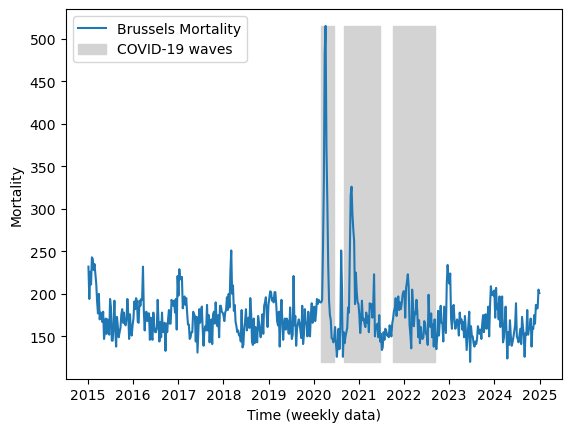

In [5]:
fig, ax = plt.subplots()
ax.plot(mortality_brussels, label='Brussels Mortality')
ax.fill_between(
    time_index,
    mortality_brussels.min(),
    mortality_brussels.max(),
    where=covid_mask,
    color='lightgrey',
    label='COVID-19 waves'
)
ax.set_ylabel('Mortality')
ax.set_xlabel('Time (weekly data)')
ax.legend()
fig

## MCSSA Without Excluding COVID-19

Baseline built on the full series, including COVID‑19 weeks:
- Useful to see how pandemic waves affect the spectrum and the extracted signal
- Expect larger low‑frequency energy and potential bias in seasonality estimates

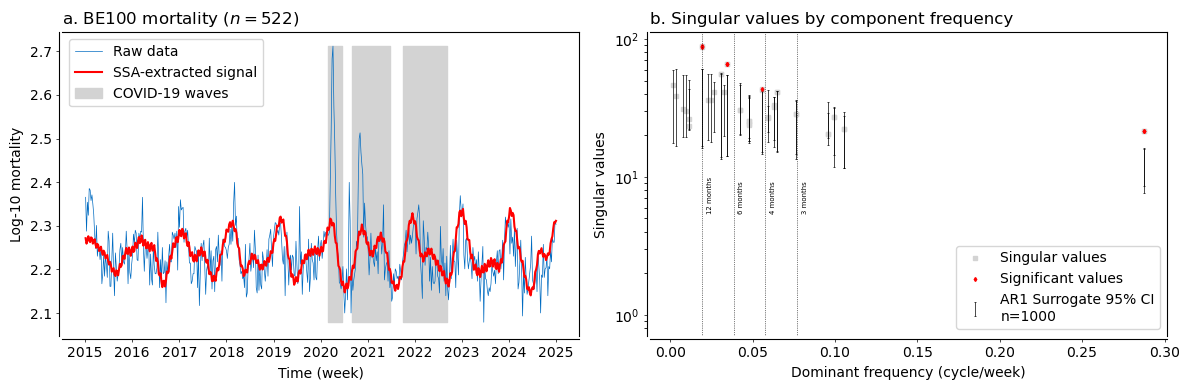

In [6]:
results = run_mcssa(
    mortality_brussels,
    n_surrogates=N_SURROGATES
)
fig, axes = plot_mcssa_results(results, mask=covid_mask)
fig

## MCSSA With COVID-19 Exclusion and Cutoff Frequency

Baseline built after excluding COVID‑19 weeks and limiting components by frequency:
- Pass `mask=covid_mask` to ignore pandemic weeks during decomposition; gaps can be filled via SSA
- Set `max_frequency=4/52` to keep components with periods ≥ ~13 weeks, focusing on seasonal/trend
- Often yields a cleaner seasonal baseline less impacted by extreme shocks

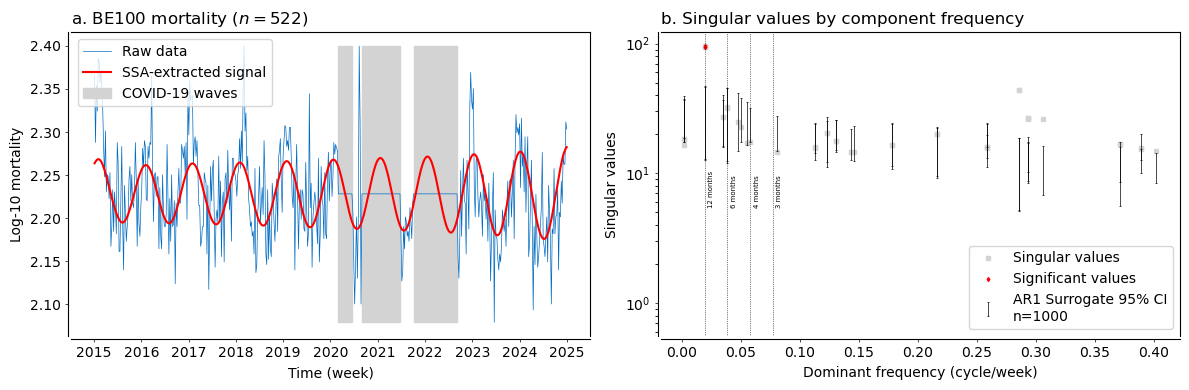

In [7]:
results_interp = run_mcssa(
    mortality_brussels,
    mask=covid_mask,
    max_frequency = 4./52,
    n_surrogates=N_SURROGATES
)
fig, axes = plot_mcssa_results(results_interp, mask=covid_mask)
fig

## Key points
- MCSSA identifies significant components; masking COVID‑19 weeks avoids affecting the baseline
- A frequency cutoff (e.g., 4/52) focuses reconstruction on smooth seasonal/trend scales
- For gap filling, use `/mortality_modelling/ssa_fill_na.py` → `fill_na(..., strategy='monte_carlo' | 'basic')`